# **Data Preparation**

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Subset

import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torchvision.datasets as DS
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import random_split, DataLoader

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import Dataset

# Intialize a custom Dataset Class for transformation and normalization

class CIFAR10GrayColorPair(Dataset):
    def __init__(self, root, train=True, download=True, transform=None):
        self.color_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Mean and Std of 0.5 is applied to R, G, B Channel
        ])
        self.gray_transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
        # Load CIFAR-10 dataset
        self.color_dataset = datasets.CIFAR10(root=root, train=train, download=download, transform=self.color_transform)
        self.gray_dataset = datasets.CIFAR10(root=root, train=train, download=False, transform=self.gray_transform)

    def __getitem__(self, index):
        # Get the color image and its corresponding gray image
        color_img, _ = self.color_dataset[index]
        gray_img, _ = self.gray_dataset[index]

        return gray_img, color_img

    def __len__(self):
        return len(self.color_dataset)

# Usage
root = './data'

cifar10_gray_color_pair_dataset = CIFAR10GrayColorPair(root=root, train=True, download=True)
test_dataset = CIFAR10GrayColorPair(root=root, train=False, download=True)


100%|██████████| 170M/170M [00:13<00:00, 13.0MB/s]


In [3]:
# Split the dataset into train and validation sets
train_size = 40000
validation_size = 10000
train_dataset, validation_dataset = random_split(cifar10_gray_color_pair_dataset, [train_size, validation_size])

In [4]:
# Dataloader to load batches of data
batch_size = 64
# You can create DataLoader instances to iterate over these datasets if needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
def imshow(img,gray=False):
    # remove the impact of normalization
    img = img / 2 + 0.5
    npimg = img.numpy()
    if gray:
      plt.imshow(np.transpose(npimg, (1, 2, 0)),cmap='gray')
    else:
      plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

## Visualize a sample of Image Data

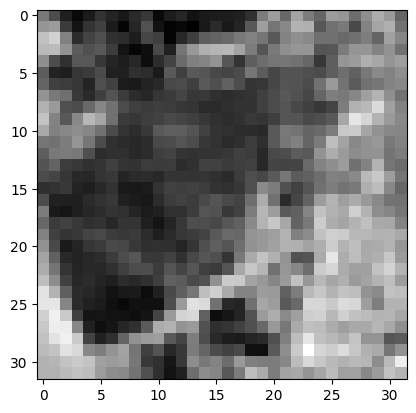

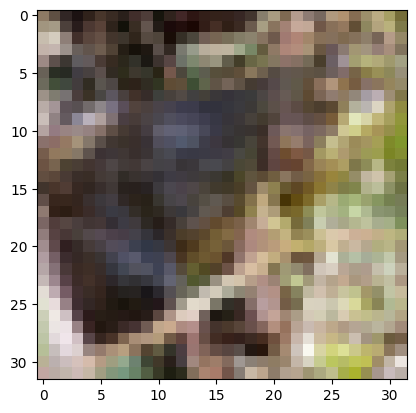

In [6]:
data_iter = iter(train_loader)
images_grey, images_rgb = next(data_iter)
imshow(images_grey[0], True)
imshow(images_rgb[0])

# **Generator**

The image dimension is 3x32x32

In [7]:
#complete the code
class Generator(nn.Module):
    def __init__(self, kernel, num_filters, num_colours=3, num_in_channels=1):
        super().__init__()

        # Parameters
        stride = 2
        padding = kernel // 2

        self.downconv1 = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.downconv2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2))

        # Add an additional convolutional layer
        self.downconv3 = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters*4, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*4),
            nn.ReLU(),
            nn.MaxPool2d(2))

        self.rfconv = nn.Sequential(
            nn.Conv2d(num_filters*4, num_filters*4, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*4),
            nn.ReLU())

        # skip connection decder layer
        self.skip1 = nn.Sequential(
            nn.Conv2d(num_filters*8, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.Upsample(scale_factor=2))
        self.skip2 = nn.Sequential(
            nn.Conv2d(num_filters*4, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        self.skip3 = nn.Sequential(
            nn.Conv2d(num_filters*2, 3, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)

        self.skip4 = nn.Sequential(
            nn.Conv2d(4, 3, kernel_size=kernel, padding=padding))

        self.final_act = nn.Tanh()
    def forward(self, x):
        # 1x32x32
        out1 = self.downconv1(x) # num_filters x 16 x 16
        out2 = self.downconv2(out1) # num_filters*2 x 8 x 8
        out3 = self.downconv3(out2) # num_filters*4 x 4 x 4

        out4 = self.rfconv(out3) # num_filters*4 x 4 x 4

        out_skip1=self.skip1(torch.cat((out4,out3),dim=1)) # num_filters*2 x 8 x 8
        out_skip2=self.skip2(torch.cat((out2,out_skip1),dim=1)) # num_filters x 16 x 16
        out_skip3=self.skip3(torch.cat((out1,out_skip2),dim=1)) # 3x 32x32

        out=self.skip4(torch.cat((x,out_skip3),dim=1)) # 3x 32x32
        out=self.final_act(out)
        return out


# **Discriminator**

In [8]:
import torch.nn.functional as F

class Discriminator(nn.Module):
    def __init__(self, kernel, num_filters, num_colours=3, num_in_channels=1):
        super().__init__()

        # Useful parameters
        stride = 2
        padding = kernel // 2
        output_padding = 1
        self.num_filters=num_filters

        # Define the layers
        self.conv1 = nn.Conv2d(num_colours + 1, num_filters, kernel_size=kernel, padding=padding)
        self.conv2 = nn.Conv2d(num_filters, num_filters * 2, kernel_size=kernel, padding=padding)
        self.maxpool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(num_filters * 2 * num_filters * num_filters, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)


    def forward(self, x, img_greyscale):
        # Concatenate the input x with the grayscale image
        x = torch.cat([x, img_greyscale], 1)

        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = self.maxpool(out)
        out = out.view(-1, self.num_filters * 2 * self.num_filters * self.num_filters)
        out = F.leaky_relu(self.fc1(out), 0.2)
        out = F.leaky_relu(self.fc2(out), 0.2)
        out = F.leaky_relu(self.fc3(out), 0.2)
        out = F.sigmoid(self.fc4(out))


        return out.squeeze()

In [9]:
# TO BE COMPLETED
from torchsummary import summary
import torch

model = Discriminator(3, 16)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
# Call the summary function with the dummy input
summary(model, [(3, 32, 32),(1,32,32)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             592
            Conv2d-2           [-1, 32, 32, 32]           4,640
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Linear-4                  [-1, 128]       1,048,704
            Linear-5                   [-1, 64]           8,256
            Linear-6                   [-1, 32]           2,080
            Linear-7                    [-1, 1]              33
Total params: 1,064,305
Trainable params: 1,064,305
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 12.00
Forward/backward pass size (MB): 0.44
Params size (MB): 4.06
Estimated Total Size (MB): 16.50
----------------------------------------------------------------


# **Train**

INTEGRATINGN LAB COLOR SPACE. Take the first channel which is the grayscale image as input and predict the next two color channel. the final result is the concatenation of the predicted two channle with the input grayscale channel.

instead of feeding in noises to the generator, we are using the output from the dropout layer

In [20]:
# Dataloader to load batches of data
batch_size = 100
# You can create DataLoader instances to iterate over these datasets if needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [21]:
def test(test_loader,batch_size):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  discriminator.eval()
  generator.eval()
  with torch.no_grad():
    for i, (xs, ys) in enumerate(test_loader):
        img_grey = xs.to(device)
        img_rgb = ys.to(device)

        # train with real images
        real_validity = discriminator(img_rgb, img_grey)

        real_loss = criterion(real_validity, torch.ones(batch_size).to(device))
        '''
        Real images from the dataset, which should be classified as real. Therefore, we use labels of ones (torch.ones(batch_size).cuda())
        because we want to encourage the discriminator to output values close to 1 for real images, indicating that it recognizes them as real.
        '''
        # train with fake images
        z=img_grey

        fake_images = generator(z)
        fake_validity = discriminator(fake_images, img_grey)

        fake_loss = criterion(fake_validity, torch.zeros(batch_size).to(device))
        '''
        Fake images are generated by the generator using img_grey (grayscale images) and passed through the discriminator to get fake_validity scores,
        with loss calculated against labels of zeros, representing fake images.
        '''
        d_loss = real_loss + fake_loss

        z=img_grey
        #z = Variable(torch.randn(batch_size, 100)).cuda()
        fake_images = generator(z)
        validity = discriminator(fake_images, img_grey)

        g_loss = criterion(validity, torch.ones(batch_size).to(device))



  return d_loss.cpu().detach(),g_loss.cpu().detach()


In [22]:
import torchvision.models as models
import torch.nn.functional as F

# Load a pretrained VGG19 model for perceptual loss
vgg = models.vgg19(pretrained=True).features[:16].to(device)  # Use first 16 layers
vgg.eval()  # Set to evaluation mode

# Function to extract VGG features
def extract_vgg_features(img):
    return vgg(img)  # Pass image through VGG

# Perceptual Loss (High-Level Feature Similarity)
def perceptual_loss(fake, real):
    fake_features = extract_vgg_features(fake)
    real_features = extract_vgg_features(real)
    return F.mse_loss(fake_features, real_features)  # MSE between VGG features

# Adversarial Loss (WGAN-based Loss)
def adversarial_loss(fake_validity):
    return -torch.mean(fake_validity)  # WGAN loss

# Total Variation (TV) Loss (Reduces Artifacts)
def tv_loss(img):
    return torch.mean(torch.abs(img[:, :, :, :-1] - img[:, :, :, 1:])) + \
           torch.mean(torch.abs(img[:, :, :-1, :] - img[:, :, 1:, :]))  # Horizontal & vertical differences

# Combined Generator Loss Function
def generator_loss(fake_images, real_images, discriminator, lambda_p=1.0, lambda_tv=0.1):
    fake_validity = discriminator(fake_images, img_grey)  # Discriminator's output on fake images

    adv_loss = adversarial_loss(fake_validity)  # WGAN loss
    perc_loss = perceptual_loss(fake_images, real_images)  # VGG Perceptual loss
    tv_loss_val = tv_loss(fake_images)  # Total Variation loss

    total_loss = adv_loss + lambda_p * perc_loss + lambda_tv * tv_loss_val  # Combine losses
    return total_loss, adv_loss, perc_loss, tv_loss_val


In [23]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def imshow(img, is_gray=False):
    # Undo normalization
    img = img * 0.5 + 0.5
    npimg = img.numpy()

    if is_gray:
        plt.imshow(np.transpose(npimg, (1, 2, 0)).squeeze(), cmap='gray')
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

def display_predictions(grayscale, sample_color, predicted, n=5):
    #plt.figure(figsize=(15, 10))

    for i in range(n):
        plt.subplot(3, n, i + 1)  # Display grayscale images in the first row
        imshow(grayscale[i].cpu(), True)

        plt.subplot(3, n, i + 1 + n)  # Display sample color images in the second row
        imshow(sample_color[i].cpu())  # Assuming sample_color images are already in CPU and normalized

        plt.subplot(3, n, i + 1 + 2 * n)  # Display predicted color images in the third row
        imshow(predicted[i].cpu())  # Assuming predicted images are already in CPU and normalized
    plt.savefig('visualize.png')
    plt.show()


In [24]:
data_iter = iter(validation_loader)
sample_gray, sample_color = next(data_iter)
sample_gray, sample_color = sample_gray[:5], sample_color[:5]

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator(3, 32).to(device)
discriminator = Discriminator(3, 16).to(device)

criterion = nn.BCELoss()
#d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=4e-5, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
#g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

lambda_adv = 0.5  # Increase from 0.1 to 0.5
lambda_p = 1.0    # Keep Perceptual loss weight
lambda_tv = 0.1   # Keep TV loss weight


train_losses = []
valid_losses = []
valid_accs = []

epochs=50

d_losses_train=[]
g_losses_train=[]
d_losses_valid=[]
g_losses_valid=[]
d_losses_test=[]
g_losses_test=[]

Epoch 0: G_loss = 2.661054849624634, Adv = -0.20255759358406067, Perc = 5.686310291290283, TV = 0.20457351207733154, D_loss = 0.810232400894165


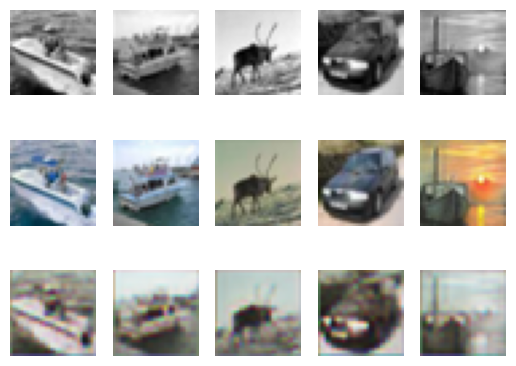

Epoch 1: G_loss = 2.0389087200164795, Adv = -0.1497027426958084, Perc = 4.338380813598633, TV = 0.1942116618156433, D_loss = 0.7145665884017944


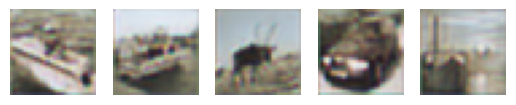

Epoch 2: G_loss = 1.922164797782898, Adv = -0.25006335973739624, Perc = 4.302709579467773, TV = 0.20873373746871948, D_loss = 0.8523761034011841


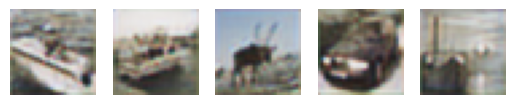

Epoch 3: G_loss = 1.6388320922851562, Adv = -0.2815802991390228, Perc = 3.798027276992798, TV = 0.21398746967315674, D_loss = 1.079107403755188


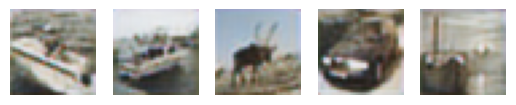

Epoch 4: G_loss = 1.4742372035980225, Adv = -0.318647176027298, Perc = 3.5431203842163086, TV = 0.2132420390844345, D_loss = 1.0170707702636719


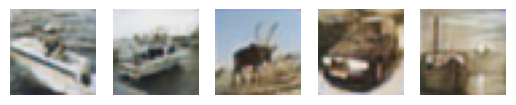

Epoch 5: G_loss = 1.4374128580093384, Adv = -0.3838224709033966, Perc = 3.598710060119629, TV = 0.21880266070365906, D_loss = 1.1435291767120361


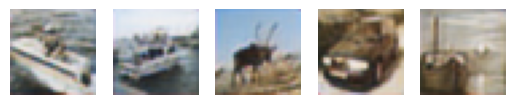

Epoch 6: G_loss = 1.3859801292419434, Adv = -0.32388877868652344, Perc = 3.375950574874878, TV = 0.2189357578754425, D_loss = 1.0447783470153809


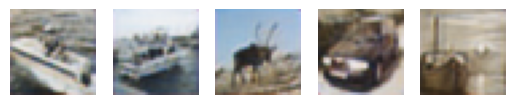

Epoch 7: G_loss = 1.4970918893814087, Adv = -0.30888545513153076, Perc = 3.567892074584961, TV = 0.22031310200691223, D_loss = 1.1244127750396729


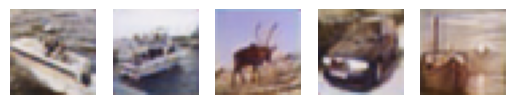

Epoch 8: G_loss = 1.4254963397979736, Adv = -0.3052937686443329, Perc = 3.417182445526123, TV = 0.22198890149593353, D_loss = 1.1526079177856445


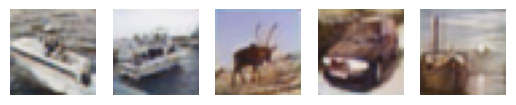

Epoch 9: G_loss = 1.272697925567627, Adv = -0.33768051862716675, Perc = 3.177506446838379, TV = 0.21625220775604248, D_loss = 1.1002726554870605


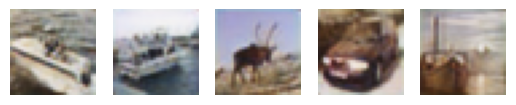

Epoch 10: G_loss = 1.322109580039978, Adv = -0.33284690976142883, Perc = 3.2652523517608643, TV = 0.22330285608768463, D_loss = 1.0285513401031494


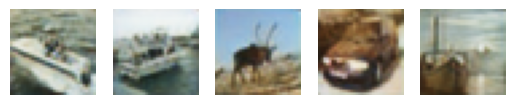

Epoch 11: G_loss = 1.4786548614501953, Adv = -0.2816111445426941, Perc = 3.4765172004699707, TV = 0.22007425129413605, D_loss = 1.0133440494537354


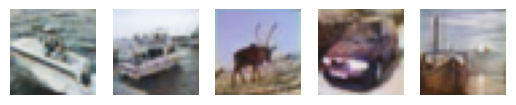

Epoch 12: G_loss = 1.2381254434585571, Adv = -0.2931138277053833, Perc = 3.0181832313537598, TV = 0.22147637605667114, D_loss = 1.0368061065673828


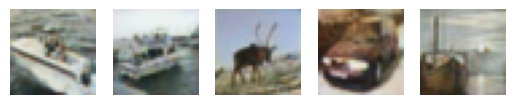

Epoch 13: G_loss = 1.262654185295105, Adv = -0.3465828001499176, Perc = 3.174988031387329, TV = 0.21742980182170868, D_loss = 1.1639682054519653


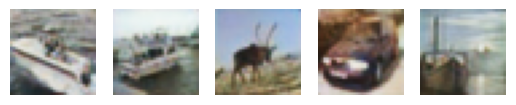

Epoch 14: G_loss = 1.2815395593643188, Adv = -0.29563549160957336, Perc = 3.109914541244507, TV = 0.22217777371406555, D_loss = 1.0323508977890015


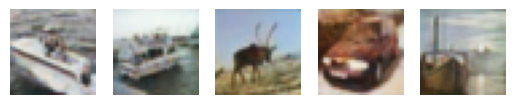

Epoch 15: G_loss = 1.317358136177063, Adv = -0.3377706706523895, Perc = 3.2669057846069336, TV = 0.2167598307132721, D_loss = 1.0756691694259644


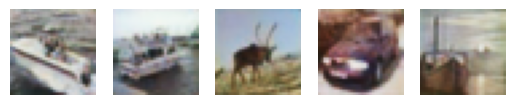

Epoch 16: G_loss = 1.2470638751983643, Adv = -0.3625377118587494, Perc = 3.175041437149048, TV = 0.22080864012241364, D_loss = 1.115060567855835


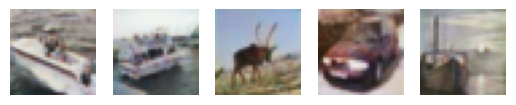

Epoch 17: G_loss = 1.024280071258545, Adv = -0.38135814666748047, Perc = 2.766348123550415, TV = 0.22464121878147125, D_loss = 1.0921964645385742


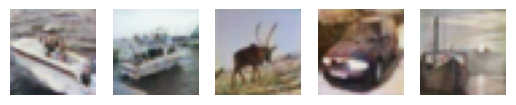

Epoch 18: G_loss = 0.9354248046875, Adv = -0.38582366704940796, Perc = 2.599113941192627, TV = 0.2169150412082672, D_loss = 1.184268593788147


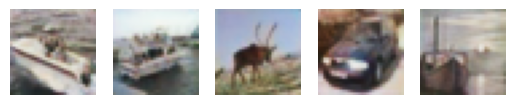

Epoch 19: G_loss = 1.0492841005325317, Adv = -0.35967379808425903, Perc = 2.77316951751709, TV = 0.22373095154762268, D_loss = 1.1390738487243652


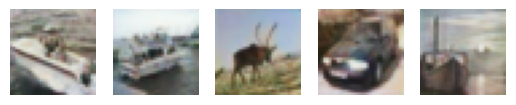

Epoch 20: G_loss = 0.8773442506790161, Adv = -0.4357609152793884, Perc = 2.580037832260132, TV = 0.2308623492717743, D_loss = 1.1543017625808716


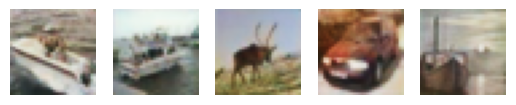

Epoch 21: G_loss = 1.1669567823410034, Adv = -0.3357553482055664, Perc = 2.9616241455078125, TV = 0.21900063753128052, D_loss = 1.1762160062789917


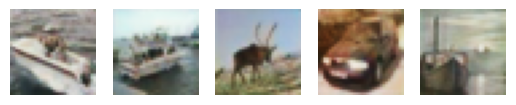

Epoch 22: G_loss = 0.9347724914550781, Adv = -0.37793293595314026, Perc = 2.581393003463745, TV = 0.22008900344371796, D_loss = 1.2188054323196411


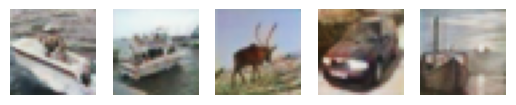

Epoch 23: G_loss = 1.1164122819900513, Adv = -0.3651919364929199, Perc = 2.9185445308685303, TV = 0.22331976890563965, D_loss = 1.1605687141418457


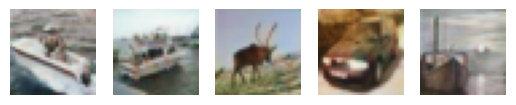

Epoch 24: G_loss = 1.1686010360717773, Adv = -0.2802440822124481, Perc = 2.8499367237091064, TV = 0.2387678325176239, D_loss = 1.0946178436279297


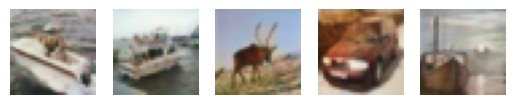

Epoch 25: G_loss = 1.1946256160736084, Adv = -0.2732713520526886, Perc = 2.8933300971984863, TV = 0.2123183310031891, D_loss = 0.9804264903068542


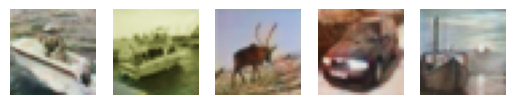

Epoch 26: G_loss = 1.0532805919647217, Adv = -0.3400937616825104, Perc = 2.7429802417755127, TV = 0.2188415825366974, D_loss = 1.061391830444336


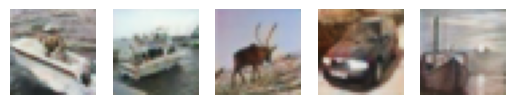

Epoch 27: G_loss = 0.9789716601371765, Adv = -0.30570387840270996, Perc = 2.524341106414795, TV = 0.22504976391792297, D_loss = 1.0474097728729248


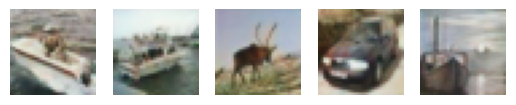

Epoch 28: G_loss = 1.25650954246521, Adv = -0.29385608434677124, Perc = 3.0542542934417725, TV = 0.23238447308540344, D_loss = 0.9207891225814819


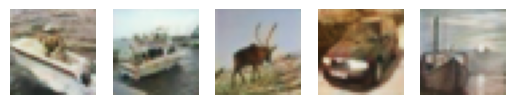

Epoch 29: G_loss = 1.2649279832839966, Adv = -0.16431716084480286, Perc = 2.813981533050537, TV = 0.22254380583763123, D_loss = 0.829805850982666


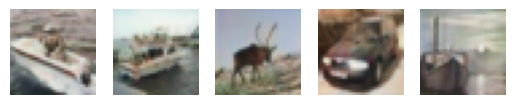

Epoch 30: G_loss = 1.080234169960022, Adv = -0.26954400539398193, Perc = 2.6550352573394775, TV = 0.22260518372058868, D_loss = 0.8822801113128662


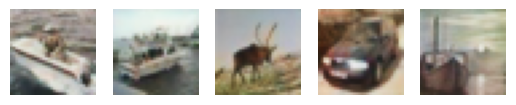

Epoch 31: G_loss = 1.2289477586746216, Adv = -0.17661313712596893, Perc = 2.7672994136810303, TV = 0.219111829996109, D_loss = 0.8507308959960938


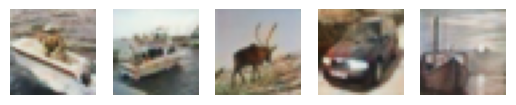

Epoch 32: G_loss = 0.9417830109596252, Adv = -0.21511031687259674, Perc = 2.27018666267395, TV = 0.21799983084201813, D_loss = 0.8719226717948914


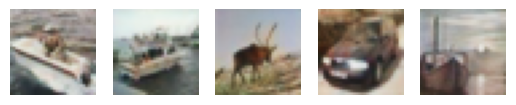

Epoch 33: G_loss = 1.0101696252822876, Adv = -0.24170775711536407, Perc = 2.462388038635254, TV = 0.20683404803276062, D_loss = 0.9463406801223755


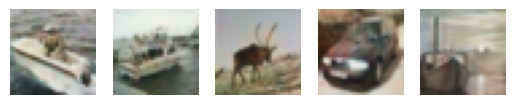

Epoch 34: G_loss = 1.084750771522522, Adv = -0.17200680077075958, Perc = 2.4681828022003174, TV = 0.22666262090206146, D_loss = 0.9046968221664429


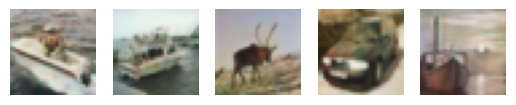

Epoch 35: G_loss = 1.162781834602356, Adv = -0.22059814631938934, Perc = 2.7219018936157227, TV = 0.2242901772260666, D_loss = 0.8552640080451965


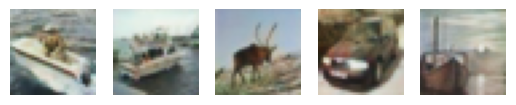

Epoch 36: G_loss = 1.225190281867981, Adv = -0.13715969026088715, Perc = 2.6814677715301514, TV = 0.2161615490913391, D_loss = 0.8219987154006958


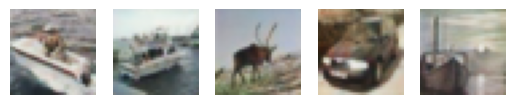

Epoch 37: G_loss = 1.0266214609146118, Adv = -0.21877281367778778, Perc = 2.4440622329711914, TV = 0.23363107442855835, D_loss = 0.8329219818115234


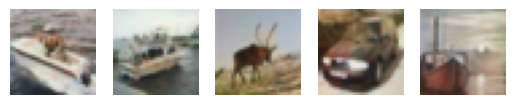

Epoch 38: G_loss = 1.027241826057434, Adv = -0.20208793878555298, Perc = 2.413071870803833, TV = 0.22793921828269958, D_loss = 0.8260714411735535


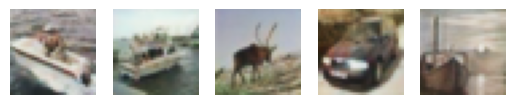

Epoch 39: G_loss = 0.9838555455207825, Adv = -0.1620180457830429, Perc = 2.247894287109375, TV = 0.21926483511924744, D_loss = 0.7770276069641113


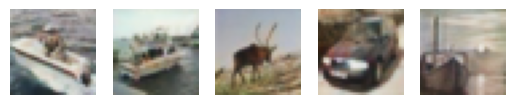

Epoch 40: G_loss = 0.9423837065696716, Adv = -0.1573730856180191, Perc = 2.156797170639038, TV = 0.21358203887939453, D_loss = 0.7631667852401733


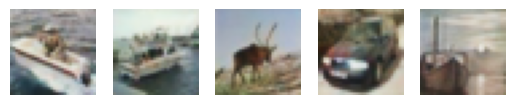

Epoch 41: G_loss = 1.1534218788146973, Adv = -0.14189831912517548, Perc = 2.545478343963623, TV = 0.22580952942371368, D_loss = 0.8574163913726807


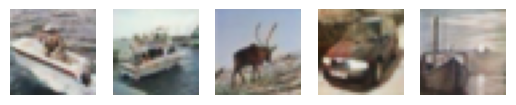

Epoch 42: G_loss = 1.021881341934204, Adv = -0.18436601758003235, Perc = 2.3719770908355713, TV = 0.2025875747203827, D_loss = 0.8111182451248169


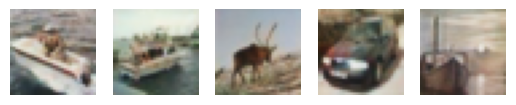

Epoch 43: G_loss = 0.9778323173522949, Adv = -0.14826324582099915, Perc = 2.2087442874908447, TV = 0.21723416447639465, D_loss = 0.7604272365570068


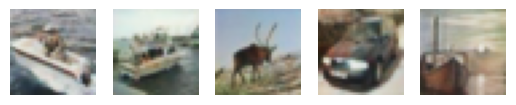

Epoch 44: G_loss = 0.966959536075592, Adv = -0.14214569330215454, Perc = 2.1761813163757324, TV = 0.21014584600925446, D_loss = 0.7635456323623657


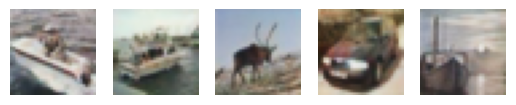

Epoch 45: G_loss = 1.206640362739563, Adv = -0.14336854219436646, Perc = 2.654388427734375, TV = 0.22814621031284332, D_loss = 0.7536541819572449


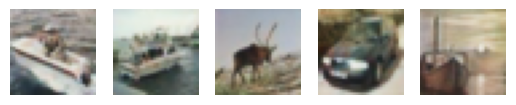

Epoch 46: G_loss = 0.9559165239334106, Adv = -0.1880652904510498, Perc = 2.2450006008148193, TV = 0.21481537818908691, D_loss = 0.7761348485946655


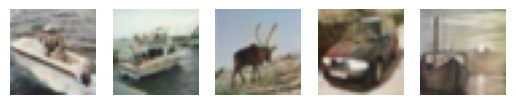

Epoch 47: G_loss = 0.9527127742767334, Adv = -0.21901343762874603, Perc = 2.2992498874664307, TV = 0.22101257741451263, D_loss = 0.783380389213562


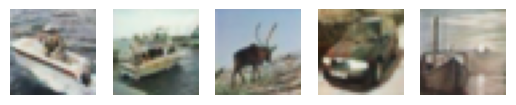

Epoch 48: G_loss = 1.0038923025131226, Adv = -0.16088275611400604, Perc = 2.286296844482422, TV = 0.21626625955104828, D_loss = 0.7755216956138611


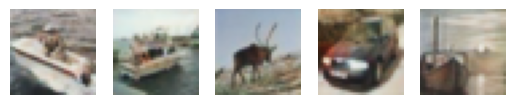

Epoch 49: G_loss = 0.9438608288764954, Adv = -0.1529208868741989, Perc = 2.1519041061401367, TV = 0.2082967758178711, D_loss = 0.7492014169692993


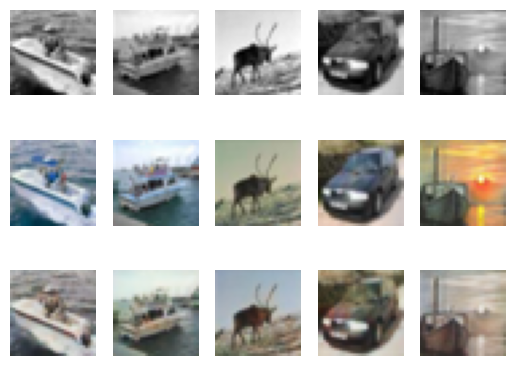

In [26]:
for epoch in range(epochs):
    generator.train()
    discriminator.train()

    for i, (xs, ys) in enumerate(train_loader):
        img_grey = xs.to(device)
        img_rgb = ys.to(device)


        real_labels = torch.full((img_grey.shape[0],), 0.9, device=device)
        fake_labels = torch.full((img_grey.shape[0],), 0.1, device=device)


        # =====================
        # TRAIN DISCRIMINATOR
        # =====================
        d_optimizer.zero_grad()

        # Discriminator predicts if real RGB images are real
        real_validity = discriminator(img_rgb, img_grey)
        real_loss = criterion(real_validity, real_labels)

        # Generate fake images
        fake_images = generator(img_grey)
        fake_validity = discriminator(fake_images.detach(), img_grey)  # Detach to prevent Generator updates

        # Discriminator predicts if fake images are fake
        fake_loss = criterion(fake_validity, fake_labels)

        # Total Discriminator loss
        d_loss = real_loss + fake_loss
        d_loss.backward()
        d_optimizer.step()

        # =====================
        # TRAIN GENERATOR
        # =====================
        g_optimizer.zero_grad()

        # Generate fake images again
        fake_images = generator(img_grey)
        g_loss, adv_loss, perc_loss, tv_loss_val = generator_loss(fake_images, img_rgb, discriminator,lambda_adv,lambda_tv)

        g_loss.backward()
        g_optimizer.step()

    # =====================
    # VALIDATION
    # =====================
    d_loss_test, g_loss_test = test(test_loader, batch_size)
    d_loss_valid, g_loss_valid = test(validation_loader, batch_size)

    d_losses_test.append(d_loss_test.cpu().detach())
    g_losses_test.append(g_loss_test.cpu().detach())

    d_losses_valid.append(d_loss_valid.cpu().detach())
    g_losses_valid.append(g_loss_valid.cpu().detach())

    d_losses_train.append(d_loss.cpu().detach())
    g_losses_train.append(g_loss.cpu().detach())

    # =====================
    # PRINT AND VISUALIZE
    # =====================
    print(f"Epoch {epoch}: G_loss = {g_loss.item()}, Adv = {adv_loss.item()}, Perc = {perc_loss.item()}, TV = {tv_loss_val.item()}, D_loss = {d_loss.item()}")

    with torch.no_grad():
        predicted_color_images = generator(sample_gray.to(device))

    if epoch == 0 or epoch == epochs - 1:
        display_predictions(sample_gray, sample_color, predicted_color_images, n=5)
    else:
        n = 5
        for i in range(5):
            plt.subplot(3, n, i + 1 + 2 * n)  # Display predicted color images in the third row
            imshow(predicted_color_images[i].cpu())
        plt.show()


In [ ]:
import matplotlib.pyplot as plt

def plot_losses(epochs, train_losses, test_losses,valid_losses, title):
    """
    Plots the generator and discriminator losses over epochs.

    :param epochs: List or array of epoch numbers.
    :param gen_losses: List or array of generator losses.
    :param disc_losses: List or array of discriminator losses.
    :param title: Title for the plot.
    """
    epochs = list(range(1, epochs + 1))
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Training')
    plt.plot(epochs, test_losses, label='Testing ')
    plt.plot(epochs, valid_losses, label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    #plt.show()

In [ ]:
plot_losses(epochs, d_losses_train, d_losses_valid,d_losses_test, 'Discriminator Loss')

plot_losses(epochs, g_losses_train, g_losses_valid,  g_losses_test,'Generator Loss')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

save_path = "/content/drive/My Drive/model_checkpoint_gan.pth"

# Save model and optimizer states
torch.save({
    'model_state': generator.state_dict(),
    'optimizer_state': g_optimizer.state_dict(),
}, save_path)

print(f"Model saved to {save_path} 🎉")


Model saved to /content/drive/My Drive/model_checkpoint_gan.pth 🎉


# Save Train Model

In [ ]:
# Save the model state and optimizer state
state = {
    'model_state': generator.state_dict()
}

# Save to a file
torch.save(state, 'model_checkpoint_gan_updated.pth')

In [ ]:
generator = Generator(3,32).to(device)

In [ ]:
# Load the state
state = torch.load('/content/model_checkpoint_gan_updated.pth')

# Restore the model and optimizer state
generator.load_state_dict(state['model_state'])

# Optional

In [ ]:
import torch

# Load the state and force it to CPU
state = torch.load('/content/model_checkpoint_gan_updated.pth', map_location=torch.device('cpu'))

# Restore the model and optimizer state
generator.load_state_dict(state['model_state'])
generator.to(torch.device('cpu'))  # Ensure model is on CPU

if 'optimizer_state' in state:
    g_optimizer.load_state_dict(state['optimizer_state'])
    for param_group in g_optimizer.param_groups:
        param_group['lr'] = 1e-4  # Set learning rate manually if needed

print("Model successfully loaded on CPU!")


Model successfully loaded on CPU!


<ipython-input-25-ba8013c26878>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('/content/model_checkpoint_gan_updated.pth', map_location=torch.device('c

# **Evaluation**

In [ ]:
!pip install colormath
!pip install lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:03<00:00, 68.0MB/s]


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Evaluating Training Set...


/usr/local/lib/python3.11/dist-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_location='cpu'), st

Results for Training Set:
PSNR: 25.4578
SSIM: 0.9370
LPIPS: 0.0236

Evaluating Testing Set...
Results for Testing Set:
PSNR: 23.9565
SSIM: 0.9225
LPIPS: 0.0374

Evaluating Validation Set...
Results for Validation Set:
PSNR: 23.9300
SSIM: 0.9216
LPIPS: 0.0378


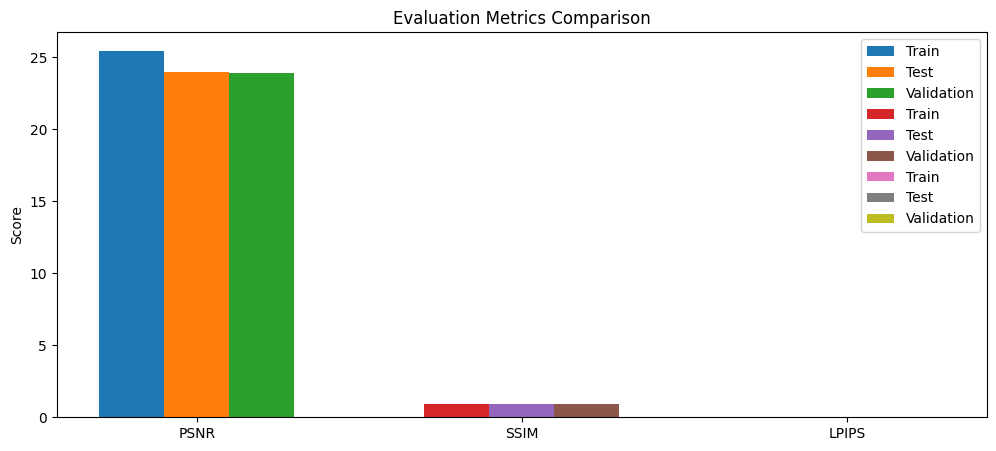

In [ ]:
import torch
import torch.nn.functional as F
import torchvision.models as models
from skimage.metrics import structural_similarity as ssim
# from torchmetrics.image.fid import FrechetInceptionDistance
import lpips
import numpy as np
from colormath.color_objects import LabColor
from colormath.color_diff import delta_e_cie2000
from torchvision import transforms
import matplotlib.pyplot as plt

# ========================
# 1. Set up device
# ========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========================
# 2. Define Metrics
# ========================

# (A) PSNR (Pixel-Level Similarity)
def compute_psnr(real, generated):
    mse = F.mse_loss(real, generated)
    return 10 * torch.log10(1 / mse)  # Assuming normalized [0,1] pixel values

# (B) SSIM (Structural Similarity)
# def compute_ssim(real, generated):
#     real_np = real.cpu().numpy().transpose(1, 2, 0)  # Convert to (H, W, C)
#     generated_np = generated.cpu().numpy().transpose(1, 2, 0)
#     return ssim(real_np, generated_np, multichannel=True)
def compute_ssim(real, generated):
    """
    Compute SSIM between real and generated images.
    Automatically sets `win_size` based on image size to avoid errors.
    """
    real_np = real.cpu().numpy().transpose(1, 2, 0)  # Convert to (H, W, C)
    generated_np = generated.cpu().numpy().transpose(1, 2, 0)

    # Ensure `win_size` is <= smallest image dimension
    min_dim = min(real_np.shape[0], real_np.shape[1])
    win_size = min(7, min_dim)  # Ensure win_size is at most 7

    return ssim(real_np, generated_np, data_range=1.0, channel_axis=-1, win_size=win_size)


# (C) FID (Fréchet Inception Distance) - Measures feature similarity
# fid = FrechetInceptionDistance(feature=2048).to(device)

# (D) LPIPS (Perceptual Similarity)
lpips_loss = lpips.LPIPS(net='alex').to(device)

# (E) Delta E (Color Difference in LAB Space)
def compute_delta_e(real_lab, generated_lab):
    color1 = LabColor(*real_lab)
    color2 = LabColor(*generated_lab)
    return delta_e_cie2000(color1, color2)

# Convert RGB to LAB color space
rgb_to_lab = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Lambda(lambda img: np.array(img.convert("LAB")) / 255.0)  # Normalize LAB values
])

def denormalize(tensor):
    """
    Convert a normalized image tensor (range [-1,1]) back to [0,1] for evaluation.
    """
    mean = torch.tensor([0.5, 0.5, 0.5]).view(1, 3, 1, 1).to(tensor.device)  # Match shape
    std = torch.tensor([0.5, 0.5, 0.5]).view(1, 3, 1, 1).to(tensor.device)
    return tensor * std + mean  # Undo normalization
def evaluate_model(generator, dataloader, dataset_name=""):
    generator.eval()  # Set model to evaluation mode

    psnr_scores = []
    ssim_scores = []
    fid_real_features = []
    fid_generated_features = []
    lpips_scores = []
    delta_e_scores = []

    with torch.no_grad():
        for i, (xs, ys) in enumerate(dataloader):  # xs = grayscale, ys = ground truth color
            img_grey = xs.to(device)
            img_rgb = ys.to(device)  # Ground truth color images

            # Generate fake color images
            generated_images = generator(img_grey)

            # ✅ Denormalize before computing metrics
            img_rgb = denormalize(img_rgb).clamp(0, 1)  # Ground truth
            generated_images = denormalize(generated_images).clamp(0, 1)  # Generated images

            # ======================
            # Compute Metrics
            # ======================
            for real, generated in zip(img_rgb, generated_images):
                # PSNR
                psnr_scores.append(compute_psnr(real, generated).item())

                # SSIM
                ssim_scores.append(compute_ssim(real, generated))

                # FID - Extract features from real and generated images
                # fid_real_features.append(real.unsqueeze(0))  # Batch dimension
                # fid_generated_features.append(generated.unsqueeze(0))

                # LPIPS
                lpips_scores.append(lpips_loss(real.unsqueeze(0), generated.unsqueeze(0)).item())

                # Delta E (Color Difference)
                # real_lab = rgb_to_lab(real.cpu())
                # generated_lab = rgb_to_lab(generated.cpu())
                # delta_e_scores.append(compute_delta_e(real_lab.mean(axis=(0,1)), generated_lab.mean(axis=(0,1))))

    # Compute final FID Score
    # fid.update(torch.cat(fid_real_features, dim=0), real=True)
    # fid.update(torch.cat(fid_generated_features, dim=0), real=False)
    # fid_score = fid.compute().item()

    # Compute Mean Scores
    results = {
        "PSNR": np.mean(psnr_scores),
        "SSIM": np.mean(ssim_scores),
        # "FID": fid_score,
        "LPIPS": np.mean(lpips_scores),
        # "DeltaE": np.mean(delta_e_scores)
    }

    print(f"Results for {dataset_name}:")
    for metric, score in results.items():
        print(f"{metric}: {score:.4f}")

    return results

# ========================
# 4. Run Evaluation on Train, Test, and Validation Sets
# ========================
print("Evaluating Training Set...")
train_results = evaluate_model(generator, train_loader, dataset_name="Training Set")

print("\nEvaluating Testing Set...")
test_results = evaluate_model(generator, test_loader, dataset_name="Testing Set")

print("\nEvaluating Validation Set...")
valid_results = evaluate_model(generator, validation_loader, dataset_name="Validation Set")

# ========================
# 5. Plot Results
# ========================
datasets = ["Train", "Test", "Validation"]
metrics = ["PSNR", "SSIM", "LPIPS"]
# metrics = ["PSNR", "SSIM", "FID", "LPIPS", "DeltaE"]

train_values = list(train_results.values())
test_values = list(test_results.values())
valid_values = list(valid_results.values())

plt.figure(figsize=(12, 5))
for i, metric in enumerate(metrics):
    plt.bar(i - 0.2, train_values[i], width=0.2, label="Train")
    plt.bar(i, test_values[i], width=0.2, label="Test")
    plt.bar(i + 0.2, valid_values[i], width=0.2, label="Validation")

plt.xticks(range(len(metrics)), metrics)
plt.ylabel("Score")
plt.legend()
plt.title("Evaluation Metrics Comparison")
plt.show()


***PSNR Metric Calculation***

# **Visualization**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def imshow(img, is_gray=False):
    # Undo normalization
    img = img * 0.5 + 0.5
    npimg = img.numpy()

    if is_gray:
        plt.imshow(np.transpose(npimg, (1, 2, 0)).squeeze(), cmap='gray')
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

def display_predictions(grayscale, sample_color, predicted, n=5):
    #plt.figure(figsize=(15, 10))

    for i in range(n):
        plt.subplot(3, n, i + 1)  # Display grayscale images in the first row
        imshow(grayscale[i].cpu(), True)

        plt.subplot(3, n, i + 1 + n)  # Display sample color images in the second row
        imshow(sample_color[i].cpu())  # Assuming sample_color images are already in CPU and normalized

        plt.subplot(3, n, i + 1 + 2 * n)  # Display predicted color images in the third row
        imshow(predicted[i].cpu())  # Assuming predicted images are already in CPU and normalized
    plt.savefig('visualize.png')
    plt.show()

In [ ]:
data_iter = iter(train_loader)

In [ ]:
sample_gray, sample_color = next(data_iter)

25.134986721978475
26.990034259988068
26.068719739129182
16.499497871769762
26.163448301570362


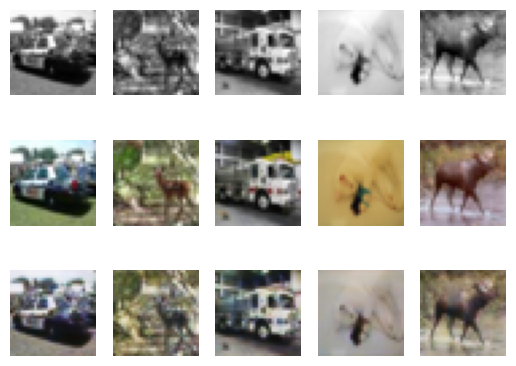

In [ ]:
sample_gray, sample_color = sample_gray[:5], sample_color[:5]
# Generate and display predictions after each epoch
model.eval()
with torch.no_grad():

    predicted_color_images = generator(sample_gray.cuda())

    for i in range(5):
        print(psnr(sample_color[i], predicted_color_images[i]))

    display_predictions(sample_gray, sample_color, predicted_color_images, n=5)

In [ ]:
data_iter = iter(test_loader)

In [ ]:
sample_gray, sample_color = next(data_iter)

17.455061293269935
25.650543103784056
25.24222866390447
27.036415624495817
21.581012828677505


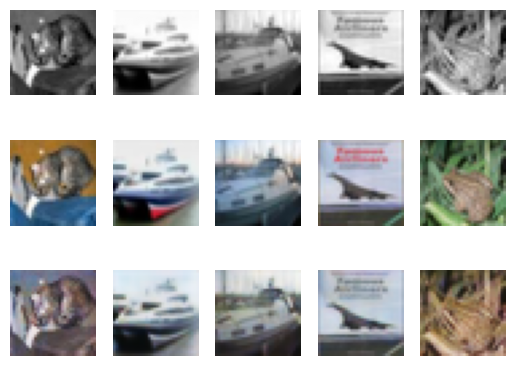

In [ ]:
sample_gray, sample_color = sample_gray[:5], sample_color[:5]
# Generate and display predictions after each epoch
model.eval()
with torch.no_grad():
    predicted_color_images = generator(sample_gray.cuda())

    for i in range(5):
        print(psnr(sample_color[i], predicted_color_images[i]))
    display_predictions(sample_gray, sample_color, predicted_color_images, n=5)

In [ ]:
data_iter = iter(validation_loader)


In [ ]:
sample_gray, sample_color = next(data_iter)
sample_gray, sample_color = next(data_iter)

19.324750078932144
27.699075172211465
18.69215923493916
19.13175866220503
21.897683977187338


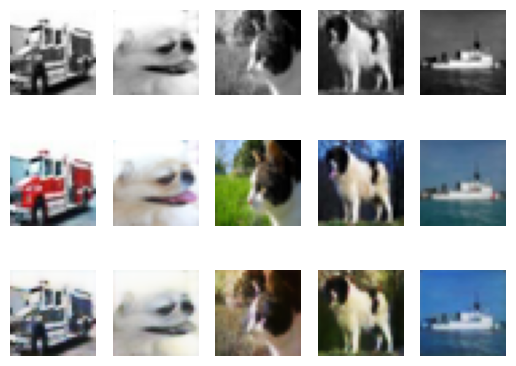

In [ ]:
sample_gray, sample_color = sample_gray[:5], sample_color[:5]
# Generate and display predictions after each epoch
model.eval()
with torch.no_grad():
    predicted_color_images = generator(sample_gray.cuda())
    for i in range(5):
        print(psnr(sample_color[i], predicted_color_images[i]))
    display_predictions(sample_gray, sample_color, predicted_color_images, n=5)